Python program in Jupyter Lab to extract data from TCGA MAF-file pan-cancer data and plot mutations in specified genes ranked by total mutational burden for each of the 96 mutation types in trinucleotide context.

In [1]:
cancer_type='uterineCorpusEndometrialCarcinoma'
gene='PTEN'

In [2]:
import pandas
import altair
from altair import Axis,Chart,Color,Scale,X,Y
altair.data_transformers.enable('default',max_rows=None)

DataTransformerRegistry.enable('default')

In [3]:
bases=('A','C','G','T')
compDic={'A':'T','T':'A','C':'G','G':'C'}
desiredVar=('Nonsense_Mutation','Missense_Mutation','Silent')

In [4]:
def processLine(row):
    if row['Reference_Allele'] in ('C','T') and row['Tumor_Seq_Allele2'] in bases: return row['Reference_Allele']+'>'+row['Tumor_Seq_Allele2']+' '+row['CONTEXT'][4:7]
    if row['Reference_Allele'] in ('A','G') and row['Tumor_Seq_Allele2'] in bases: return str(compDic.get(row['Reference_Allele']))+'>'+str(compDic.get(row['Tumor_Seq_Allele2']))+' '+''.join(compDic.get(i) for i in row['CONTEXT'][4:7][::-1])
    if row['Reference_Allele'] not in bases or row['Tumor_Seq_Allele2'] not in bases: return 'NA'

In [5]:
df=pandas.read_csv(cancer_type,sep='\t')
df['Mutation_Type']=df.apply(lambda row:processLine(row),axis=1)
df=df[(df['Mutation_Type']!='NA')&(df['Variant_Classification'].isin(desiredVar))]

In [6]:
df['Mutation_Type_Count']=df.groupby(['Tumor_Sample_Barcode','Mutation_Type'])['Mutation_Type'].transform('count')
df=df[['Hugo_Symbol','Variant_Classification','Tumor_Sample_Barcode','Mutation_Type','Mutation_Type_Count']]
df_deduplicated=df.drop_duplicates(subset=('Tumor_Sample_Barcode','Mutation_Type'))

In [7]:
df_deduplicated['Patient_Mutation_Type_Rank']=df_deduplicated.groupby('Mutation_Type')['Mutation_Type_Count'].rank(method='first',ascending=False)
df_deduplicated_reduced=df_deduplicated[['Tumor_Sample_Barcode','Mutation_Type','Patient_Mutation_Type_Rank']]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
df_ranked=pandas.merge(df,df_deduplicated_reduced,how='left',on=['Tumor_Sample_Barcode','Mutation_Type'])

In [9]:
df_ranked['Patient_Mutation_Type_Rank_Max']=df_ranked.groupby('Mutation_Type')['Patient_Mutation_Type_Rank'].transform(max)
df_ranked['Patient_Mutation_Type_Rank_Of_One']=1-(df_ranked['Patient_Mutation_Type_Rank']/df_ranked['Patient_Mutation_Type_Rank_Max'])

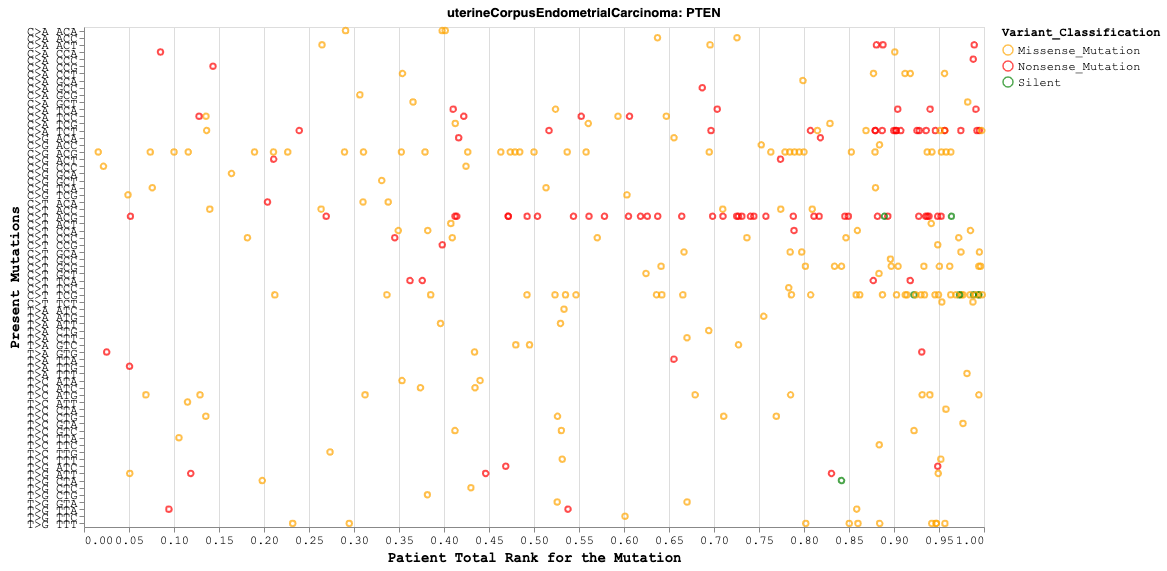

In [10]:
df_ranked_gene=df_ranked.loc[df_ranked['Hugo_Symbol']==gene]
Chart(df_ranked_gene,title=cancer_type+': '+gene).mark_point().configure_axis(labelFont='Courier New',labelFontSize=12,titleFont='Courier New',titleFontSize=14).configure_legend(titleFont='Courier New',titleFontSize=12,labelFont='Courier New',labelFontSize=12).encode(X('Patient_Mutation_Type_Rank_Of_One',axis=Axis(title='Patient Total Rank for the Mutation')),Y('Mutation_Type',axis=Axis(title='Present Mutations')),Color('Variant_Classification',scale=Scale(domain=['Missense_Mutation','Nonsense_Mutation','Silent'],range=['orange','red','green']))).properties(width=900,height=500)


In [ ]:
#df['Mutation_Type'].unique()
#df['Tumor_Sample_Barcode'].unique()

### 